In [48]:
using Gadfly, DataFrames, LightGraphs, StatsBase, ProgressMeter

In [49]:
set_default_plot_size(12cm, 8cm)

# The Imitation Model

This presentation is broken into three parts:
1. Motivation
2. Fundamentals
3. Purpose

## Part 1.
* In consideration of the meaning of intelligence, imitation is examined.


* Definition: Intelligence - "the ability to acquire and apply knowledge and skills."

* Definition: Knowledge - "facts, information, and skills acquired by a person through experience or education; the theoretical or practical understanding of a subject."

The idea is that intelligence allows the gathering of knowledge and skills; skills being knowledge stored in structures other than (but still employing the reasoning of) the neocortex i.e. muscles, the endocrine system, etc. 

What about the purpose?

Intelligence minimizes error (where error implies an adverse cost associated with the failure to optimize time collapsed-survival) via the efficient gathering of knowledge and skills.

* Consider Least squares and other techniques that attempt to learn from data.
* Data is all stimuli.
* Your dad, your mom, your TV.
* Polar bears are white

Life imitates other life such that it bypasses an inefficient phase of random trials.

### Error Minimization
Evolution: Generation dependent structural imitation.

Learning: Sub-generational structural imitation based on sensory stimuli.

Problem Solving
1. Recognition of patterns (have I seen this).
   * If so apply learned pattern.
2. Random trials.
   * Apply applicable techniques.
   * Catalog result for later use.

As an exercise try and imagine something that has components not made up of things you have seen, touched, tasted, felt, heard or smelled.

This research explores a model built only on imitation and randomness. 

## Part 2.
Imitation in a simple group.

### Rules
Consider a set of nodes $\Omega$ with a subset of nodes $M$ that move. We have $n = |\Omega|$ nodes and $m = |M|$ nodes move. 
* Each node $n_i \notin M$ can imitate a node that moved with probaility $p$. 
* Once a node has imitated another node it is considered "moved" for that turn and cannot moved again. 
* Who imitated who is lost.

In [50]:
function imitate(nodes::Int, prob::Float64, moved::Int)
    tot = 0
    for i in 1:(nodes - moved)
        for j in 1:moved
            if prob > rand() 
                tot = tot + 1 
                break
            end 
        end
    end
    tot
end

imitate (generic function with 2 methods)

In [100]:
imitate(10, .5, 5)

5

Suppose we have $n$ nodes and $m$ moved. We wish to determine how many nodes will imitate at least one of the $m$ nodes and move themselves. Each node will imitate with probability $p$. The number of nodes available to imitate is $k = n - m$. We can think of each of these $k$ nodes as having $m$ chances to imitate a node that moved:

\begin{equation*}
  X \sim\binom{m}{x}p^x(1-p)^{m-x}
\end{equation*}

A node moves if it imitated at least one of the other nodes:

\begin{equation*}
  P(X \geq 1) = 1 - P(X < 1) = 1 - (1-p)^m = z
\end{equation*}

where $z$ is the probability a node moves. 

The distribution representing the probability that $v$ nodes move is given by:

\begin{equation*}
    V \sim \binom{k}{v}z^v(1-z)^{k-v}
\end{equation*}

Thus we can determine the expected number of nodes that will move:

\begin{equation*}
  \langle V \rangle = k - k(1 - p)^m
\end{equation*}

Note the variance decreases as $p$ increases:

\begin{equation*}
  \sigma^2 = \langle V \rangle(1-p)
\end{equation*}

We write the solution for later use.

In [52]:
function expectedMoves(n::Int, p::Float64, m::Int)
    k = n - m
    mean = k - k * (1 - p)^m
    var = mean * (1 - p)
    (mean, var)
end

expectedMoves (generic function with 1 method)

In [53]:
function expectedMovesSim(n::Int, p::Float64, m::Int, trials::Int)
    im = 0
    for i in 1:trials
        im = im + imitate(n, p, m)
    end
    im / trials
end

expectedMovesSim (generic function with 1 method)

In [54]:
n = 50
p = .5
m = 1
expectedMoves(n, p, m)

(24.5,12.25)

In [55]:
expectedMovesSim(n, p, m, 10^6)

24.494993

Let's see what happens as we travel across time. Kick a node and watch the rest imitate.

In [56]:
function catalyze(nodes::Int, prob::Float64, moved::Int, limit::Int = 10^4; force = true)
    record = [1]
    itr = 1
    while moved > 0 && itr < limit
        moved = imitate(nodes, prob, moved)
        push!(record, moved)
        if force && moved == 0
            moved = 1
        end
        itr = itr + 1
    end
    record
end

catalyze (generic function with 2 methods)

Let's see what happens when we allow the process to die out.

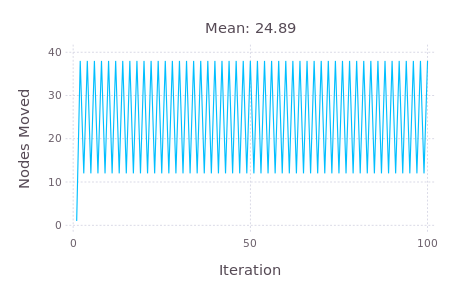

In [57]:
n, p, m = 50, .8, 1
record = catalyze(n, p, m, 10^2, force = false);
plot(x = [x for x = 1:length(record)], y = record, Geom.line,
Guide.ylabel("Nodes Moved"), Guide.xlabel("Iteration"), 
Guide.title("Mean: $(mean(record))"))

In [58]:
expectedMoves(n, p, 10)

(39.999995904,7.999999180799999)

We can see that for large $p$ the initial condition dictates the outcome whereas smaller values imply a more stochastic process.

In [59]:
function simulate(folds::Int, totalnodes::Int, numprobs::Int, probstop::Float64)
    analysisnodes::Int = totalnodes - 1
    allmoves = Array{Float64}(analysisnodes, numprobs)
    alltime = Array{Float64}(analysisnodes, numprobs)
    probs = linspace(.01, probstop, numprobs)
    a = 1
    for p in probs, i in 2:totalnodes
        avgmoves = 0
        avgtime = 0
        for j in 1:folds
            record = catalyze(i, p, 1)
            avgmoves = avgmoves + (mean(record))
            avgtime = avgtime + length(record)
        end
        allmoves[a] = avgmoves / folds
        alltime[a] = avgtime / folds
        #print("|$i, $p: $(allmoves[a])")
        a = a + 1
    end
    (allmoves, alltime)
end

simulate (generic function with 1 method)

In [60]:
folds = 10
nodes = 30 
probs = 10
probstop = .99
probvalues = linspace(1//100, probstop, probs)
(moves, time) = simulate(folds, nodes, probs, probstop);

We run a more sophisticated simulation to find the average number of moves nodes will make (over 10 folds) over time.

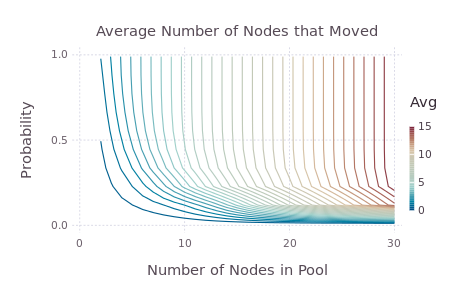

In [61]:
plot(z = moves, x = [x for x = 2:nodes], y = [x for x in probvalues],
Geom.contour(levels=30), Guide.xlabel("Number of Nodes in Pool"), Guide.ylabel("Probability"),
Guide.title("Average Number of Nodes that Moved"), Guide.colorkey("Avg"))

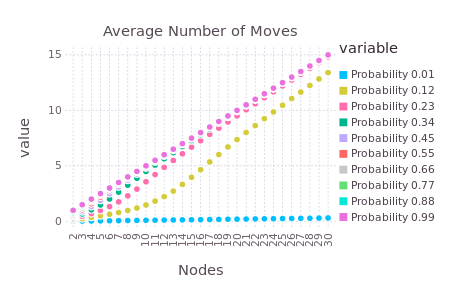

In [62]:
data = DataFrame([2:nodes moves])
names!(data, convert(Array{Symbol, 1}, ["Nodes", [symbol("Probability $x") for x in round(probvalues, 2)]]))
dat = stack(data, [2:probs + 1]);
plot(dat, x = "Nodes", y = "value", color = "variable", Geom.point,
Guide.title("Average Number of Moves"), Stat.xticks(ticks = [x for x = 2:nodes]))

* Large $p$ values forecast more predictable outcomes given the initial number of nodes that move.
* Lower $p$ values lead to states that are less stable.
* Both node number and probabiilty play a role in predicting how many moves.

The characteristics of a simple imitation model.
* If more nodes are available to imitate, the probability of a catalyst spreading increases.
* Likewise if people imitate with a higher probability spreading increases.

# Let's play a game.

Consider a network where each edge has weight $w \in A = (0,1)$ representing the probability of imitation. 
* We'll kick a node to start the process off.  
* If a node imitates another then the weight is increased by:

$$e_{ij_{t+1}} = e_{ij_{t}} + \alpha(1 - e_{ij_{t}})$$

* If a node fails to imitate another then the weight is decreased by:

$$e_{ij_{t+1}} = e_{ij_{t}} - \alpha e_{ij_{t}}$$

We have the same imiation scenario except the nodes are weighted and the weights can be adjusted.

In [63]:
"""
Given a symmetric weight matrix `W`, an ordered set of nodes that moved in the previous 
timestep, and a metric defining how to adjust the weights (when `dynamic = true`) evaluate
and return an ordered set of nodes that moved and adjust the weights of `W` accordingly.
"""
function imitate(W, moved, metric; dynamic = true)
    #print("Nodes moved $moved\n")
    n = size(W, 1)
    nodes = setdiff(IntSet(1:n), moved)
    imitated = IntSet()
    for i in nodes, j in moved
        if W[i,j] > rand()
            #print("$i imitated $j\n")
            push!(imitated, i)
            if dynamic metric(W, i, j) end 
        else
            if dynamic metric(W, i, j; strengthen = false) end
        end
    end
    imitated
end

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in anonymous at no file
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/cfusting/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/cfusting/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[62], in expression starting on line 2


imitate (generic function with 2 methods)

In [64]:
"""
Changes the probabilistic weight of the edge between two nodes.
"""
function tenth(W, i, j; strengthen = true)
    if strengthen
        p = W[i,j] + 1/10 * (1 - W[i,j])
    else
        p = W[i,j] - 1/10 * W[i,j]
    end
    #print("New distance $dist\n")
    W[i,j] = p
    W[j,i] = p
end

tenth (generic function with 1 method)

Let's examine a very simple case to start.

Consider fully connected networks.

In [65]:
"""
Get a fully connected network of `n` nodes.
"""
function getperfect(n::Int, p::Float64)
    W = zeros(n, n)
    for i in 1:n
        for j in i+1:n
            W[i,j] = p
            W[j,i] = p
        end
    end
    W
end

getperfect (generic function with 1 method)

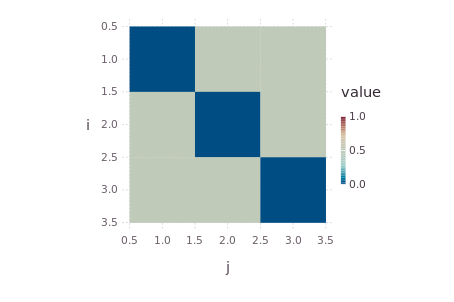

In [101]:
spy(getperfect(3,1/2), Scale.color_continuous(minvalue=0, maxvalue=1))

To better understand how the network as a whole has changed, we examine the mean weight.

In [67]:
"""
Given an undirected adjacency matrix of weights `W` compute the mean
weight between nodes.
"""
function meanweight(W)
    tot = 0.0
    ctr = 0
    for i in 1:size(W, 2), j in i+1:size(W, 1)
        tot = tot + W[i,j] 
        ctr = ctr + 1
    end
    tot / ctr
end

meanweight (generic function with 1 method)

In [68]:
"""
Given `n` fully connected nodes connected with probability `p`, kick off a simulation in which `move` nodes
move and the remaining nodes imitate and update their distances accordingly. Limit to `ϵ` change in mean distance
or `itr` iterations. Force the algorithm to run all `itr` with `force = true`.
"""
function simstaticcomp(W::Array{Float64, 2}; move::Int = 1, ϵ = 0.0001, itr::Int = 10^3, force::Bool = false)
    n = size(W, 1)
    dist = Float64[]
    weights = Array{Float64, 2}[] 
    nodemoved = Array{Int, 1}[]
    p = Progress(itr, 1)
    ctr = 1
    emax = 10^2
    ectr = 1
    nodes = []
    ldist = 1
    while ctr <= itr && (force || ectr <= emax)
        if length(nodes) == 0
            nodes = IntSet(sample(collect(1:n), move, replace = false))
            #print(nodes,"\n")
        end
        push!(nodemoved, collect(nodes))
        nodes = imitate(W, nodes, tenth)
        push!(weights, copy(W))
        cdist = meanweight(W)
        push!(dist, cdist)
        #print("ldist: $ldist | cdist: $cdist\n")
        if abs(ldist - cdist) < ϵ
            ectr = ectr + 1
        else
            ectr = 1
        end
        ldist = cdist
        ctr = ctr + 1
        next!(p)
    end
    (dist, weights, nodemoved)
end

simstaticcomp (generic function with 1 method)

Now let's take a fully connected network and kick a node.
* If nodes stop moving, kick another.
* Record the average weight at each timestep.
* If the mean weight stops changing, kill the process and save your cycles.

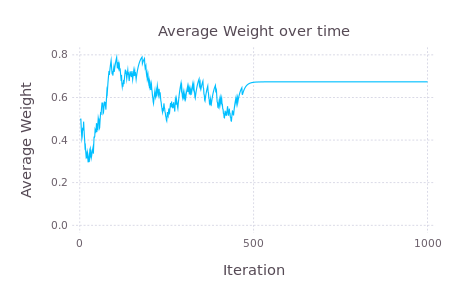

In [69]:
W = getperfect(3, .5)
(dist, weights, nodemoved) = simstaticcomp(W, force = true);
plot(x = [x for x = 1:length(dist)], 
y = [dist[i] for i = 1:length(dist)], 
Guide.xlabel("Iteration"), Guide.ylabel("Average Weight"),
Guide.title("Average Weight over time"),
Geom.line)

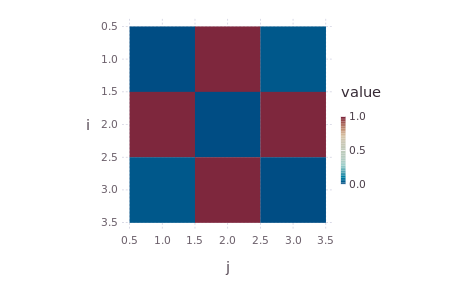

In [70]:
spy(weights[end], Scale.color_continuous(minvalue=0, maxvalue=1))

* Often, we find nodes tend toward $0$ or $1$ such that the network finds a steady state.
* However it's possible for components to develop that have edges in other states. 
* This occurs when the imitation cycle occilates between positions that prevent the odd edge from being considered.

In [71]:
function cleanweights(W, ϵ = .001)
    for i in 1:size(W, 1), j in 1:size(W, 2)
        if W[i,j] < ϵ
            W[i,j] = 0
        elseif W[i,j] > 1 - ϵ
            W[i,j] = 1
        end
    end
end

cleanweights (generic function with 2 methods)

To understand how the network 

In [72]:
cleanweights(weights[end])
weights[end]

3x3 Array{Float64,2}:
 0.0        1.0  0.0201118
 1.0        0.0  1.0      
 0.0201118  1.0  0.0      

We'd like to better understand the relationship between these steady state weight motifs and the number of nodes.

In [73]:
"""
Look for unique weight motifs that arise from an imitation simulation of `n` nodes 
fully connected with probability `p`.
"""
function getdistmotifs(n, p; itr = 10^2)
    motifs = Set{Array{Float64, 2}}()
    for i in 1:itr
        (dist, weights) = simstaticcomp(getperfect(n, p))
        W = copy(weights[end])
        cleanweights(W)
        if !(W in motifs) 
            push!(motifs, W)
        end
    end
    motifs
end

getdistmotifs (generic function with 1 method)

In [74]:
#motifs = getdistmotifs(3, .2, 10^4)

A Cursory analysis finds the frequency of unique "weight motifs" is a function of node number and probability.

In [75]:
prob = collect(.025:.025:1)
n = 5
#plot(x = [x for x in prob], y = [length(getdistmotifs(n, x, 10^4)) for x in prob],
#Guide.xlabel("Probability"), Guide.ylabel("Number of Motifs"),
#Guide.title("Weight Motif Frequency"),
#Geom.line)

5

Having explored fully connected networks we now consider Erdős–Rényi random networks in which edges are randomly weighted uniformly.

Notation:

* Components $c_i$ 
* nodes $n$
* number of nodes in $c_i \equiv n_{c_i}$
* degree $k$ 
* weights $W$
* distance $D=1-W$


1. How long does an idea bounce around $c_i$ given $k_{avg}$ and $d_{avg}$ (static and dynamic cases)?
2. How does $d_{avg}$ behave as a function of $n_{c_i}$ and $W$

In [76]:
"""
With probabilty of connection `p` generate a random symmetric adjacency matrix of uniformly 
distributed weights between 0 and 1.
"""
function randomweights(n, p, divider) 
    W = zeros(n, n)
    for i in 1:n, j in i+1:n
        if p > rand()
            r = rand() / divider
            W[i,j] = r
            W[j,i] = r
        end
    end
    W
end

randomweights (generic function with 1 method)

Given an ER random network with random weights, how does the structure change as $t \to \infty$?

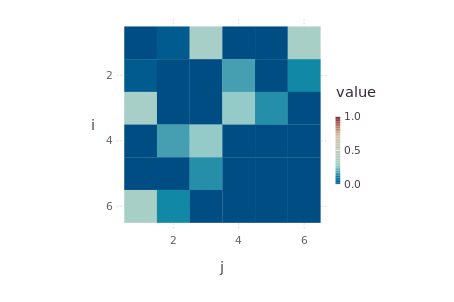

In [77]:
n, p, div = 6, 1/2, 2
W = randomweights(n, p, div)
round(W, 3)
spy(W, Scale.color_continuous(minvalue=0, maxvalue=1))

Iterations: 4

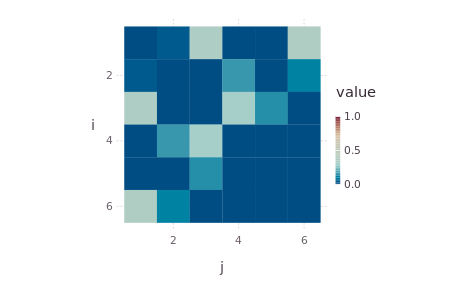

In [78]:
nodes = IntSet(sample(collect(1:n), 2, replace = false))
ctr, itr = 1, 10^3
while length(nodes) > 0 && ctr <= itr
    nodes = imitate(W, nodes, tenth)
    #print("nodes : $(length(nodes)), ctr : $ctr \n")
    ctr = ctr + 1
end
print("Iterations: $ctr")
round(W, 3)
spy(W, Scale.color_continuous(minvalue=0, maxvalue=1))

Nodes strengthen and weaken bonds to nearly $1$ or $0 \pm \epsilon_{machine}$.

* Given a random network with random weights, nodes organize themselves into trust components.
* Recall in ER networks we don't have triangles like we did in the fully connected example - Thus we don't see weight motifs.

## Components 
Let's explore how components of a network change over time within an ER space (we really need to get out of here).
* This time we'll make the weights static.
* This is a fair game with a fair start.

In [79]:
"""
With probabilty of connection `p` create a symmetric adjacency matrix of weights of weight 
`w`.
"""
function staticweights(n, p, w)
    W = zeros(n, n)
    for i in 1:n, j in i+1:n
        if p > rand()
            W[i,j] = w
            W[j,i] = w
        end
    end
    W
end

staticweights (generic function with 1 method)

In [80]:
"""
Create an undirected graph without self loops from a weigth matrix.
"""
function graphfromweights(W)
    n = size(W, 1)
    g = Graph(n)
    for i in 1:n, j in i+1:n
        if W[i,j] > 0 
            add_edge!(g, i, j)
        end
    end
    g
end

graphfromweights (generic function with 1 method)

To understand how components change define the distance metric:

$$
d_{i,j} = 1 - w_{i,j}
$$

Each component has some mean distance:

$$
c_d = \frac{1}{N} \sum_{i,j \in \Omega, i \neq j} d_{i,j}
$$

In [81]:
function visit(node, D, vis, counted, last = 0)
    #print("Visiting node $(node)!\n")
    dist = 0
    for i in 1:size(D, 2)
        if i != last && D[i, node] < 1 
            if !((i, node) in counted)
                push!(counted, (i, node))
                push!(counted, (node, i))
                dist = dist + D[i, node]
            end
            if !(i in vis)
                push!(vis, i)
                dist = dist + visit(i, D, vis, counted, node)
            end
        end
    end 
    dist
end

visit (generic function with 2 methods)

In [82]:
"""
Calculate the total distance between nodes connected to `node` in `W`.
"""
function distance(W, node)
    vis = IntSet()
    counted = Set()
    D = 1 - W
    n = size(D, 2)
    push!(vis, node)
    visit(node, D, vis, counted)
end

distance (generic function with 1 method)

In [83]:
type Component
    nodes::Array{Int}
    avgdist::Float64
    avgdeg::Float64
    size::Int
    
    Component(nodes, avgdist, avgdeg) = new(nodes, avgdist, avgdeg, length(nodes))
end

In [84]:
function calccompdist(g, W)
    res = Component[]
    coms = connected_components(g) 
    degrees = degree(g)
    for i in coms
        if length(i) > 1
            avgdeg = mean(degrees[i])
            dist = distance(W, i[1]) / length(i)
            push!(res, Component(i, dist, avgdeg))
        end
    end
    res
end

calccompdist (generic function with 1 method)

It's actually quite difficult to build an ER network that has multiple components.

In [85]:
n,p,w = 100, 1/90, 1/2
W = staticweights(n, p, w)
g = graphfromweights(W)
coms = calccompdist(g,W)

16-element Array{Component,1}:
 Component([3,19,92],0.3333333333333333,1.3333333333333333,3)             
 Component([5,43,55],0.3333333333333333,1.3333333333333333,3)             
 Component([6,44],0.25,1.0,2)                                             
 Component([8,13,31,49,62,66,81,93],0.4375,1.75,8)                        
 Component([9,29,30,50,69,70,71],0.42857142857142855,1.7142857142857142,7)
 Component([10,32,48,64,94,100],0.4166666666666667,1.6666666666666667,6)  
 Component([11,58,73],0.3333333333333333,1.3333333333333333,3)            
 Component([12,51,82,96],0.375,1.5,4)                                     
 Component([15,34],0.25,1.0,2)                                            
 Component([16,22,40,54,56,74,83,88],0.4375,1.75,8)                       
 Component([17,26,75],0.3333333333333333,1.3333333333333333,3)            
 Component([18,33,57,77],0.375,1.5,4)                                     
 Component([27,36,38,39,67],0.4,1.6,5)                               

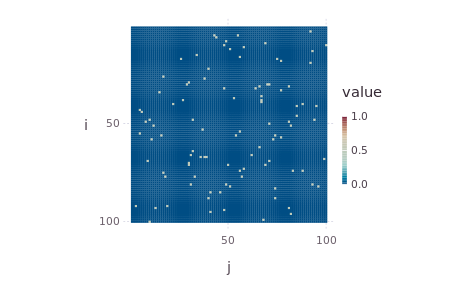

In [86]:
spy(W, Scale.color_continuous(minvalue=0, maxvalue=1))

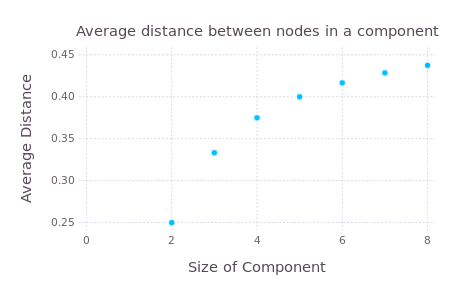

In [87]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.point)

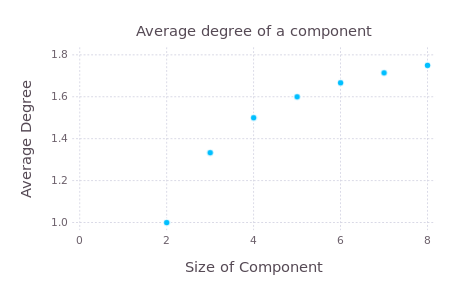

In [88]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdeg for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Degree"),
Guide.title("Average degree of a component"),
Geom.point)

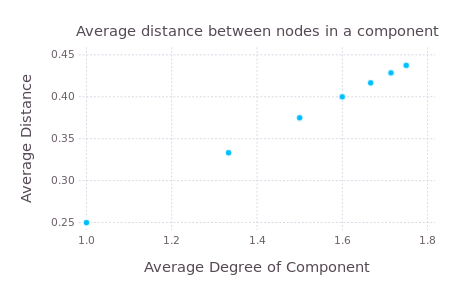

In [89]:
plot(x = [coms[i].avgdeg for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Average Degree of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.point)

Now kick off a simulation that runs for a set number of iterations. If nodes stop moving kick one.

In [90]:
move = 10
ctr = 1
itr = 10^1
p = Progress(itr, 1)
while ctr < itr
    if length(nodes) == 0
        nodes = IntSet(sample(collect(1:n), move, replace = false))
    end
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
    next!(p)
end
coms = calccompdist(g, W);

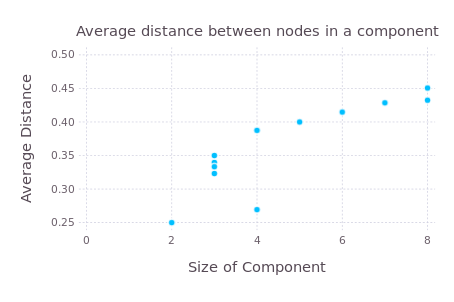

In [91]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.point)

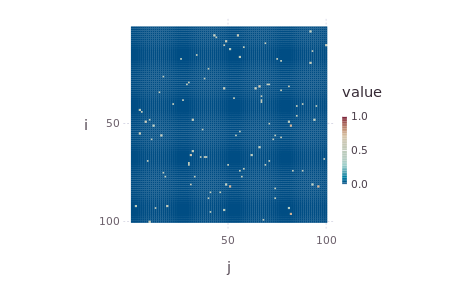

In [92]:
spy(W, Scale.color_continuous(minvalue=0, maxvalue=1))

## Part 3
* Some components build trust, others fall apart.
* The outcomes are random.